# Esercizi sull'inferenza frequentista {#sec-ttest-exercises}

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import xarray as xr
import arviz as az
import pingouin as pg

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

La tabella seguente descrive le proprietà delle distribuzioni campionarie della media, della differenza tra due medie indipendenti, della proporzione e della differenza tra due proporzioni:

| Distribuzione | Media | Varianza |
|---------------|-------|----------|
| Media campionaria | $\mu$ | $\frac{\sigma^2}{n}$ |
| Differenza tra due medie indipendenti | $\mu_1 - \mu_2$ | $\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}$ |
| Proporzione campionaria | $p$ | $\frac{p(1-p)}{n}$ |
| Differenza tra due proporzioni campionarie | $p_1 - p_2$ | $\frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}$ |

Nella tabella, $\mu$ rappresenta la media della popolazione, $\sigma$ rappresenta la deviazione standard della popolazione, $n$ rappresenta la dimensione del campione, $p$ rappresenta la proporzione della popolazione, e $n_1$ e $n_2$ rappresentano le dimensioni dei campioni delle due popolazioni considerate. La varianza è indicata come $\sigma^2$ per la media campionaria, $\sigma_1^2$ e $\sigma_2^2$ per la differenza tra due medie indipendenti, e $p_1(1-p_1)$ e $p_2(1-p_2)$ per la differenza tra due proporzioni campionarie.

L'approccio frequentista nell'inferenza statistica fa uso delle proprietà della distribuzione campionaria della statistica di test per la costruzione di intervalli di confidenza o per il test di ipotesi statistiche. 

In questo capitolo esamineremo alcuni esercizi sul test t di Student e sulla costruzione degli intervalli di confidenza.

## Inferenza statistica su una singola media

### Test $t$ di Student a un campione

Per descrivere l'inferenza su una singola media consideriamo il seguente esempio. È stato condotto uno studio di ricerca al fine di esaminare le differenze tra gli adulti anziani e quelli giovani sulla percezione della soddisfazione nella vita. Per testare questa ipotesi, è stato effettuato uno studio pilota su dati ipotetici. Il test è stato somministrato a dieci adulti anziani (oltre i 70 anni) e dieci adulti giovani (tra i 20 e i 30 anni). La scala di valutazione utilizzata ha un range di punteggi da 0 a 60, dove punteggi elevati indicano una maggiore soddisfazione nella vita e punteggi bassi indicano una minore soddisfazione. È stata scelta una scala con elevata affidabilità e validità. I dati (fittizi) raccolti sono riportati di seguito.

In [4]:
younger = np.array([45, 38, 52, 48, 25, 39, 51, 46, 55, 46])
older = np.array([34, 33, 36, 38, 37, 40, 42, 43, 32, 36])

Per ora, esaminiamo soltanto il gruppo degli adulti più anziani. Si suppponga che studi precedenti indichino che, per questo gruppo d'età, la soddisfazione della vita misurata con questo test sia pari a 60. Svolgiamo il test t di Student usando l'ipotesi nulla che nella popolazione la media sia effettivamente uguale a 40.

Inziamo a svolgere l'esercizio applicando la funzione `ttest` del modulo `pingouin`. Per l'esempio presente, poniamo $\mu_0$, la media dell'ipotesi nulla, uguale a 40. Svolgiamo l'esercizio con `ttest`.

In [5]:
res = pg.ttest(older, 40)

Esaminiamo il risultato.

In [6]:
print(res)

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.481666    9   two-sided  0.034896  [34.46, 39.74]  0.784772  2.319   

           power  
T-test  0.599895  


**Interpretazione.** Dato che il valore-p è minore di $\alpha$ = 0.05, ovvero in modo equivalente, dato che la statistica test cade nella regione di rifiuto, rifiutiamo $H_0: \mu = 40$.

Procediamo ora con i calcoli passo-passo utilizzando la formula del test t di Student. La statistica $T$ calcolata dal test è definita come:

$$
T = \frac{\bar{X} - \mathbb{E}(\bar{X})}{s / \sqrt{n}} = \frac{\bar{X} - \mu_0}{s / \sqrt{n}},
$$

dove $\bar{X}$ è la media campionaria, $\mu_0$ è l'ipotesi nulla sulla media della popolazione, $s$ è la deviazione standard campionaria e $n$ è la dimensione del campione. Tale statistica ha una semplice interpretazione: essa corrisponde alla standardizzazione della media del campione all'interno della distribuzione campionaria delle medie di ampiezza $n$ = 10. La distribuzione campionaria delle medie di ampiezza $n$ = 10 ha media $\mu_{\bar{X}} = \mu$ e varianza $\sigma^2_{\bar{X}} = \frac{\sigma^2}{n}$, dove $\mu$ è la media della popolazione e $\sigma^2$ è la varianza della popolazione da cui il campione è stato estratto. Tuttavia, poiché i parametri della popolazione sono sconosciuti, l'approccio frequentista utilizza la media $\mu_0$ ipotizzata dall'ipotesi nulla $H_0$ al posto della media sconosciuta della popolazione e stima il parametro sconosciuto $\sigma$ con la deviazione standard $s$ del campione. In queste circostanze, la statistica $T$ segue la distribuzione $t$ di Student con $n-1$ gradi di libertà *se il campione è stato estratto da una popolazione normale*. 

Svolgiamo i calcoli con Python.

In [7]:
T = (np.mean(older) - 40) / (np.std(older, ddof=1) / np.sqrt(len(older)))
T


-2.481665888425312

I gradi di libertà sono $n-1$. 

In [8]:
df = len(older) - 1
print(df)

9


Troviamo il valore-p, ovvero l'area sottesa alla distribuzione t di Student con 9 gradi di libertà nei due intervalli $[-\infty, -T]$ e $[T, +\infty]$.

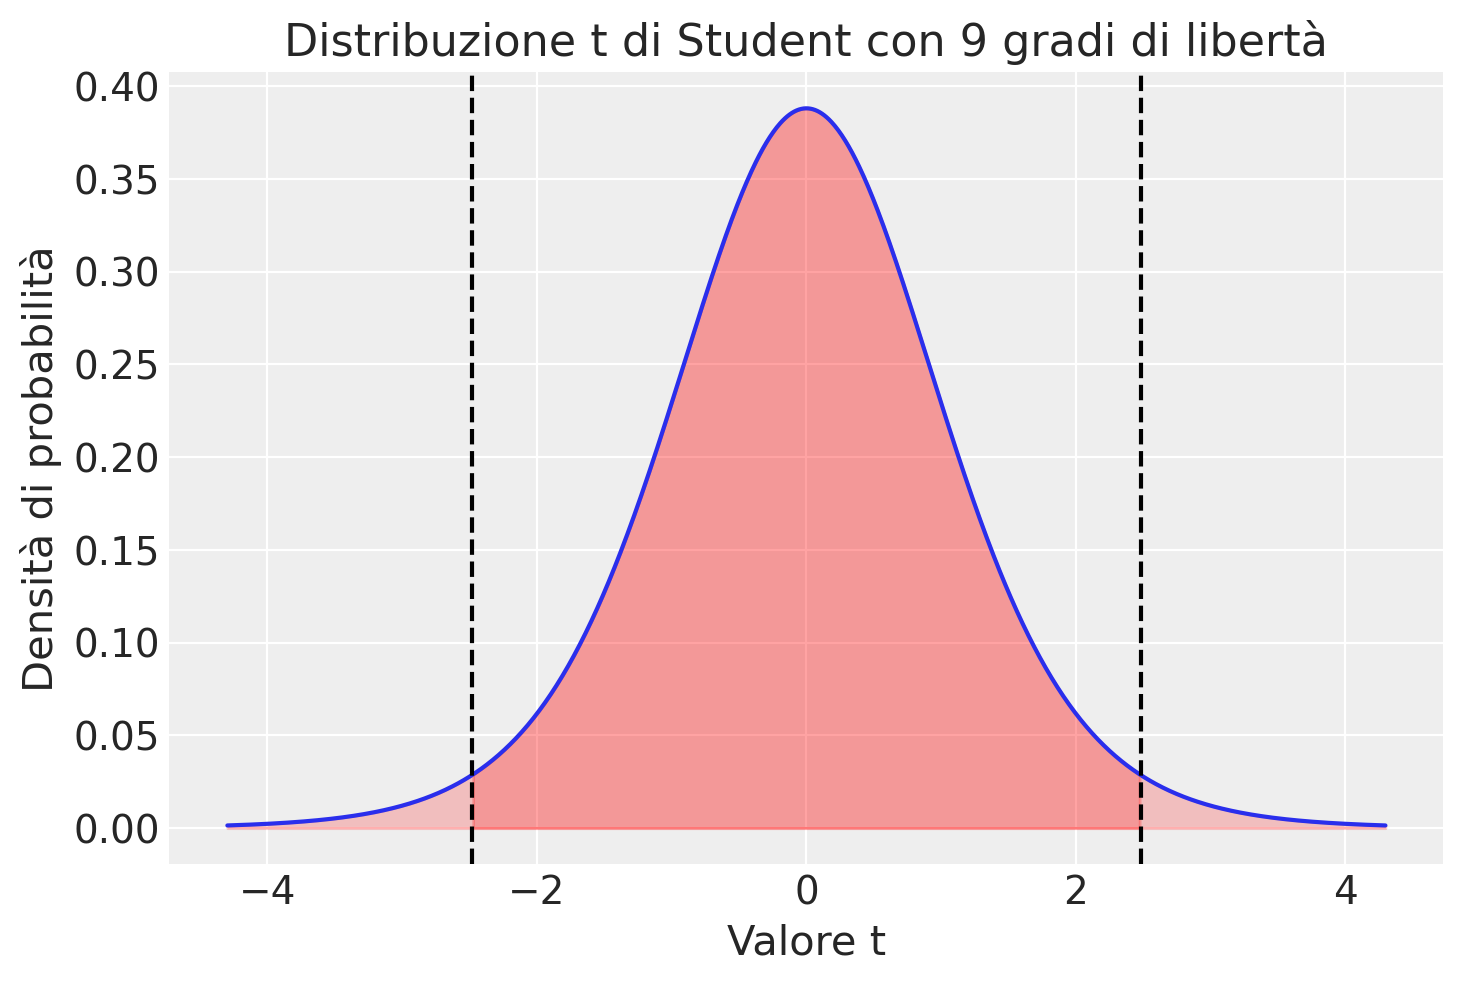

In [9]:
# Set up the x-axis values for the t-distribution plot
x = np.linspace(st.t.ppf(0.001, df), st.t.ppf(0.999, df), 1000)

# Set up the y-axis values for the t-distribution plot
y = st.t.pdf(x, df)

# Create the t-distribution plot
plt.plot(x, y, label="t-distribution")

# Shade the areas [-infinity, -T] and [T, +infinity]
plt.fill_between(x[x <= -T], y[x <= -T], color="red", alpha=0.2)
plt.fill_between(x[x >= T], y[x >= T], color="red", alpha=0.2)

# Add vertical lines for T and -T
plt.axvline(x=T, color="black", linestyle="--")
plt.axvline(x=-T, color="black", linestyle="--")


# Set the plot title and axis labels
plt.title(f"Distribuzione t di Student con {df} gradi di libertà")
plt.xlabel("Valore t")
plt.ylabel("Densità di probabilità")
plt.show()


In [10]:
st.t.cdf(T, df=len(older) - 1) * 2


0.03489593108658913

### Intervallo di confidenza per una media

Calcoliamo ora l'intervallo di confidenza al livello di fiducia del 95%. Come visto in precedenza, la procedura `ttest` ha calcolato l'intervallo di confidenza del 95% per la media della popolazione che va da 34.46 a 39.74. Questo intervallo può essere interpretato come segue: se la stessa procedura venisse applicata molte volte, in circa il 95% dei casi l'intervallo ottenuto conterrà il vero valore della media della popolazione. 

Iniziamo a trovare il valore critico della distribuzione $t$ di Student che lascia $\alpha/2$ in ciascuna coda.

In [11]:
alpha = 0.05
df # 9
t_c = st.t.ppf(1 - alpha / 2, df)
t_c

2.262157162854099

L'intervallo di confidenza è dato da

$$
\bar{X} \pm t_{n-1} \frac{s}{\sqrt{n}}.
$$

Svolgiamo i calcoli.

In [12]:
ci_lower = np.mean(older) - t_c * np.std(older, ddof=1) / np.sqrt(len(older))
ci_upper = np.mean(older) + t_c * np.std(older, ddof=1) / np.sqrt(len(older))
print("L'intervallo di confidenza al 95% per la media della popolazione è: [{:.2f}, {:.2f}].".format(ci_lower, ci_upper))

L'intervallo di confidenza al 95% per la media della popolazione è: [34.46, 39.74].


## Confronto tra medie per campioni indipendenti

### Test $t$ di Student per campioni indipendenti

Per eseguire il test t di Student per due campioni indipendenti, iniziamo svolgendo i calcoli con la funzione `ttest` del modulo `pingouin`. L'ipotesi nulla è che la differenza tra le medie delle due popolazioni sia uguale a 0: $\mu_1 - \mu_2 = 0$. La funzione `ttest` implementa la seguente formula:

$$
T = \frac{(\bar{x}_1 - \bar{x}_2) - 0}{\sqrt{
    \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}.
}},
$$


In [13]:
res = pg.ttest(younger, older, paired=False)
print(res)

               T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  2.479867   18   two-sided  0.02326  [1.13, 13.67]  1.10903  2.849   

           power  
T-test  0.650317  


Svolgiamo i calcoli passo-passo.

In [14]:
t_num = np.mean(younger) - np.mean(older)
t_denom = np.sqrt(np.var(younger, ddof=1) / len(younger) + np.var(older, ddof=1) / len(older))
T = np.divide(t_num, t_denom)
T

2.479866520313643

La statistica $T$ calcolata sopra si distribuisce con $(n_1 - 1) + (n_2 - 1)$, ovvero $n_1 + n_2 - 2$, gradi di libertà.

In [15]:
df = len(younger) + len(older) - 2
print(df)

18


Il valore-p è uguale all'area sottesa alla funzione t di Student con $n_1 + n_2 - 2$ negli intervalli $[-\infty, -T]$ e $[T, +\infty]$. Nel caso presente abbiamo

In [16]:
(1 - st.t.cdf(T, df=df)) * 2

0.023260241301116924

### Intervallo di confidenza per la differenza tra due medie

Calcoliamo ora l'intervallo di confidenza al livello di fiducia del 95% per la differenza tra le due medie. Iniziamo a calcolare il valore critico $t$.

In [17]:
alpha = 0.05
t_c = st.t.ppf(1 - alpha / 2, df)
t_c

2.10092204024096

Troviamo l'errore standard della differenza tra le due medie.

In [18]:
se_diff = np.sqrt(np.var(younger, ddof=1) / len(younger) + np.var(older, ddof=1) / len(older))
se_diff

2.9840315756446754

Troviamo i limiti inferiore e superiore dell'intervallo di confidenza al 95%.

In [19]:
ci_lower = (np.mean(younger) - np.mean(older)) - (t_c * se_diff)
ci_upper = (np.mean(younger) - np.mean(older)) + (t_c * se_diff)
print("L'intervallo di confidenza al 95% per la differenza tra le due medie è: [{:.2f}, {:.2f}].".format(ci_lower, ci_upper))

L'intervallo di confidenza al 95% per la differenza tra le due medie è: [1.13, 13.67].


Si noti che i gradi di libertà sono $n_1+n_2-2$ quando le varianze delle due popolazioni sono uguali. La formula di Welch-Satterthwaite viene usata per approssimare i gradi di libertà quando le due varianze non sono uguali:

$$
\nu \approx \frac{\left(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\right)^2}{\frac{(s_1^2/n_1)^2}{n_1 - 1} + \frac{(s_2^2/n_2)^2}{n_2 - 1}}
$$

dove $\nu$ rappresenta i gradi di libertà approssimati, $s_1^2$ e $s_2^2$ sono le varianze campionarie delle due popolazioni, $n_1$ e $n_2$ sono le dimensioni dei due campioni.

Nel caso di varianze diverse, l'argomento `correction=True` produce una correzione dei gradi di liberta con l'approssimazione di Welch-Satterthwaite e il corrispondente valore-p.

In [20]:
res1 = pg.ttest(younger, older, paired=False, correction=True)
print(res1)

               T        dof alternative     p-val          CI95%  cohen-d  \
T-test  2.479867  12.156852   two-sided  0.028738  [0.91, 13.89]  1.10903   

         BF10     power  
T-test  2.849  0.650317  


Consideriamo ora la statistica $d$ di Cohen. Il $d$ di Cohen è una misura di effetto comunemente utilizzata per valutare la differenza tra le medie di due gruppi indipendenti. La formula del $d$ di Cohen per la differenza di due medie indipendenti è la seguente:

$$
d = \frac{\bar{X}_1 - \bar{X}_2}{s},
$$

dove $\bar{X}_1$ e $\bar{X}_2$ sono le medie dei due gruppi, e $s$ è la deviazione standard raggruppata (pooled standard deviation), definita come:

$$
s = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1 + n_2 - 2}},
$$

dove $n_1$ e $n_2$ sono le dimensioni dei due gruppi e $s_1$ e $s_2$ sono le deviazioni standard dei due gruppi. Il $d$ di Cohen può essere interpretato come la differenza tra le medie dei due gruppi in unità di deviazioni standard raggruppate. Un valore di $d$ di Cohen di 0.2 è considerato un effetto piccolo, un valore di 0.5 è considerato un effetto medio e un valore di 0.8 o superiore è considerato un effetto grande.

La funzione `ttest` ha trovato un valore di 1.10903. Svolgiamo i calcoli passo-passo.

Iniziamo a calcolare la deviazione standard raggruppata (pooled standard deviation).

In [21]:
s_pool_num = np.sum(
    [
        (len(younger) - 1) * np.std(younger, ddof=1) ** 2,
        (len(older) - 1) * np.std(older, ddof=1) ** 2,
    ]
)
s_pool_denom = len(younger) + len(older) - 2

s_pool = np.sqrt(np.divide(s_pool_num, s_pool_denom))
s_pool

6.672497450147301

Troviamo ora il $d$ di Cohen.

In [22]:
d = (np.mean(younger) - np.mean(older)) / s_pool
print(d)

1.1090300229094336


**Interpretazione.** Il risultato dell'analisi suggerisce che la differenza nella soddisfazione nella vita tra i due gruppi di età, misurata tramite l'indice $d$ di Cohen, è considerevole in termini di dimensione dell'effetto.

### PyMC

Svolgiamo ora lo stesso esercizio usando l'inferenza Bayesiana. Utilizzeremo distribuzioni a priori ampie per garantire un risultato simile all'analisi frequentista. Inseriamo i dati in un DataFrame.

In [23]:
y = np.concatenate((younger, older))
x = np.concatenate((np.repeat(1, len(younger)), np.repeat(0, len(older))))
df = pd.DataFrame({"y": y, "x": x})
df.head()

,y,x
0,45,1
1,38,1
2,52,1
3,48,1
4,25,1


In [24]:
df.tail()

,y,x
15,40,0
16,42,0
17,43,0
18,32,0
19,36,0


<Axes: xlabel='x', ylabel='y'>

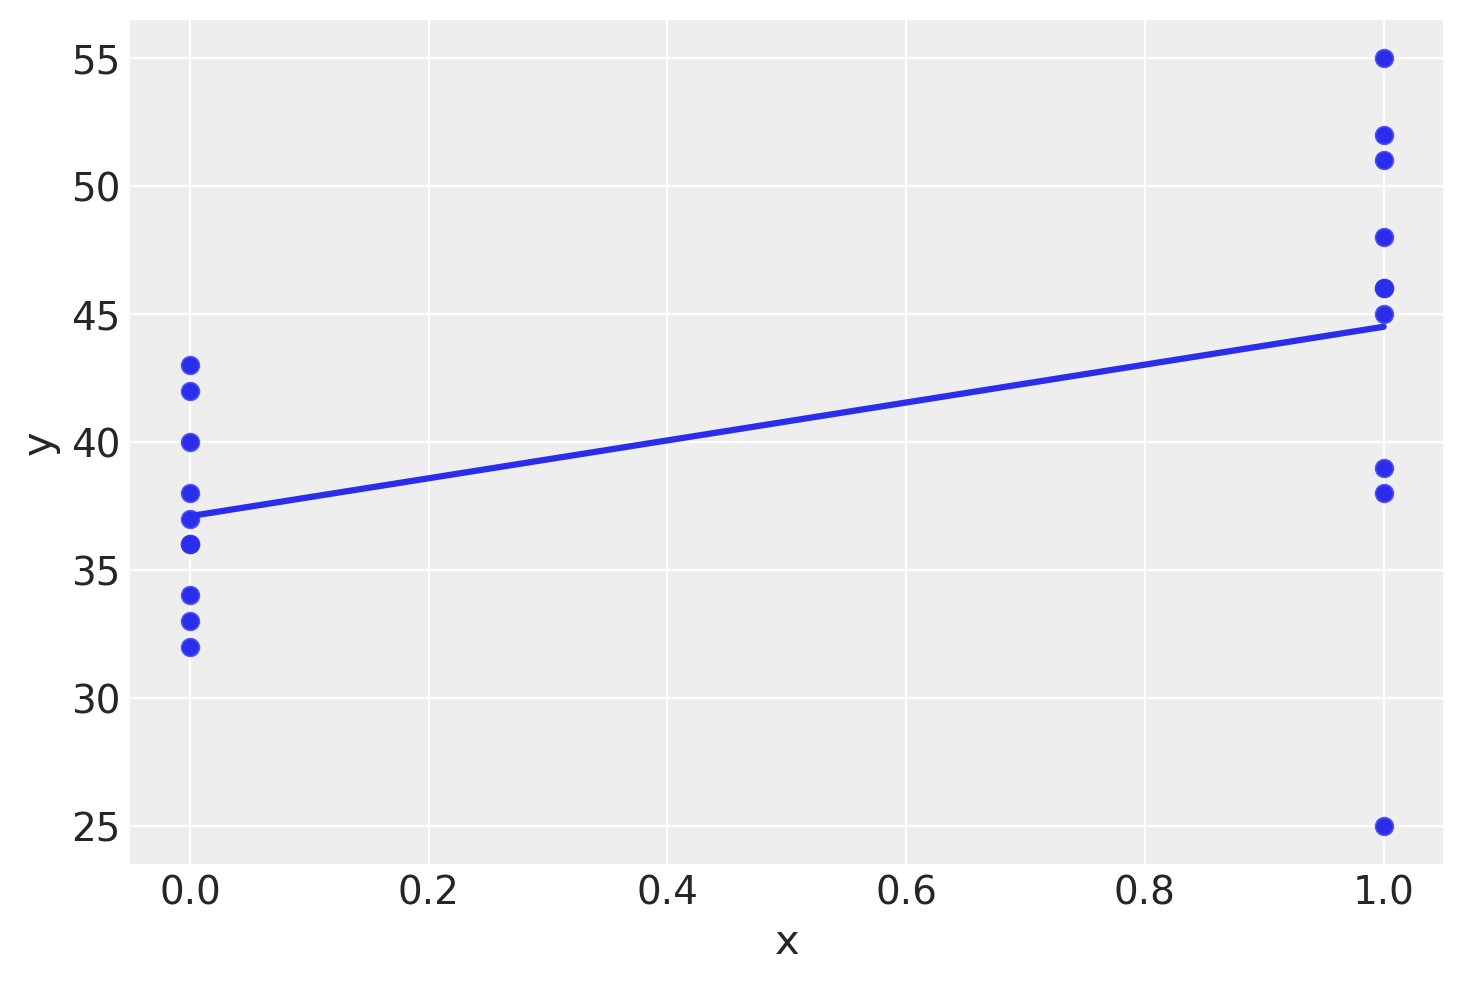

In [25]:
sns.scatterplot(x=df["x"], y=df["y"])
sns.regplot(x=df["x"], y=df["y"], ci=False)

Creaimo il modello statistico corrispondente ad un modello di regressione con un predittore dicotomico codificato con 0 per il primo gruppo e con 1 per il secondo gruppo. Iniziamo con l'analisi predittiva a priori per determinare se le distribuzioni a priori sono adeguate.

In [26]:
with Model() as model_p:

    # Priors
    alpha = Normal("alpha", mu=0, sigma=50)
    beta = Normal("beta", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=50)

    # Expected value of outcome
    mu = alpha + beta * x

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    idata_p = pm.sample_prior_predictive(samples=50)

Sampling: [Y_obs, alpha, beta, sigma]


Utilizzo lo script fornito dal sito di PyMC per generare casualmente un campione di rette di regressione dal modello utilizzando le distribuzioni a priori specificate.

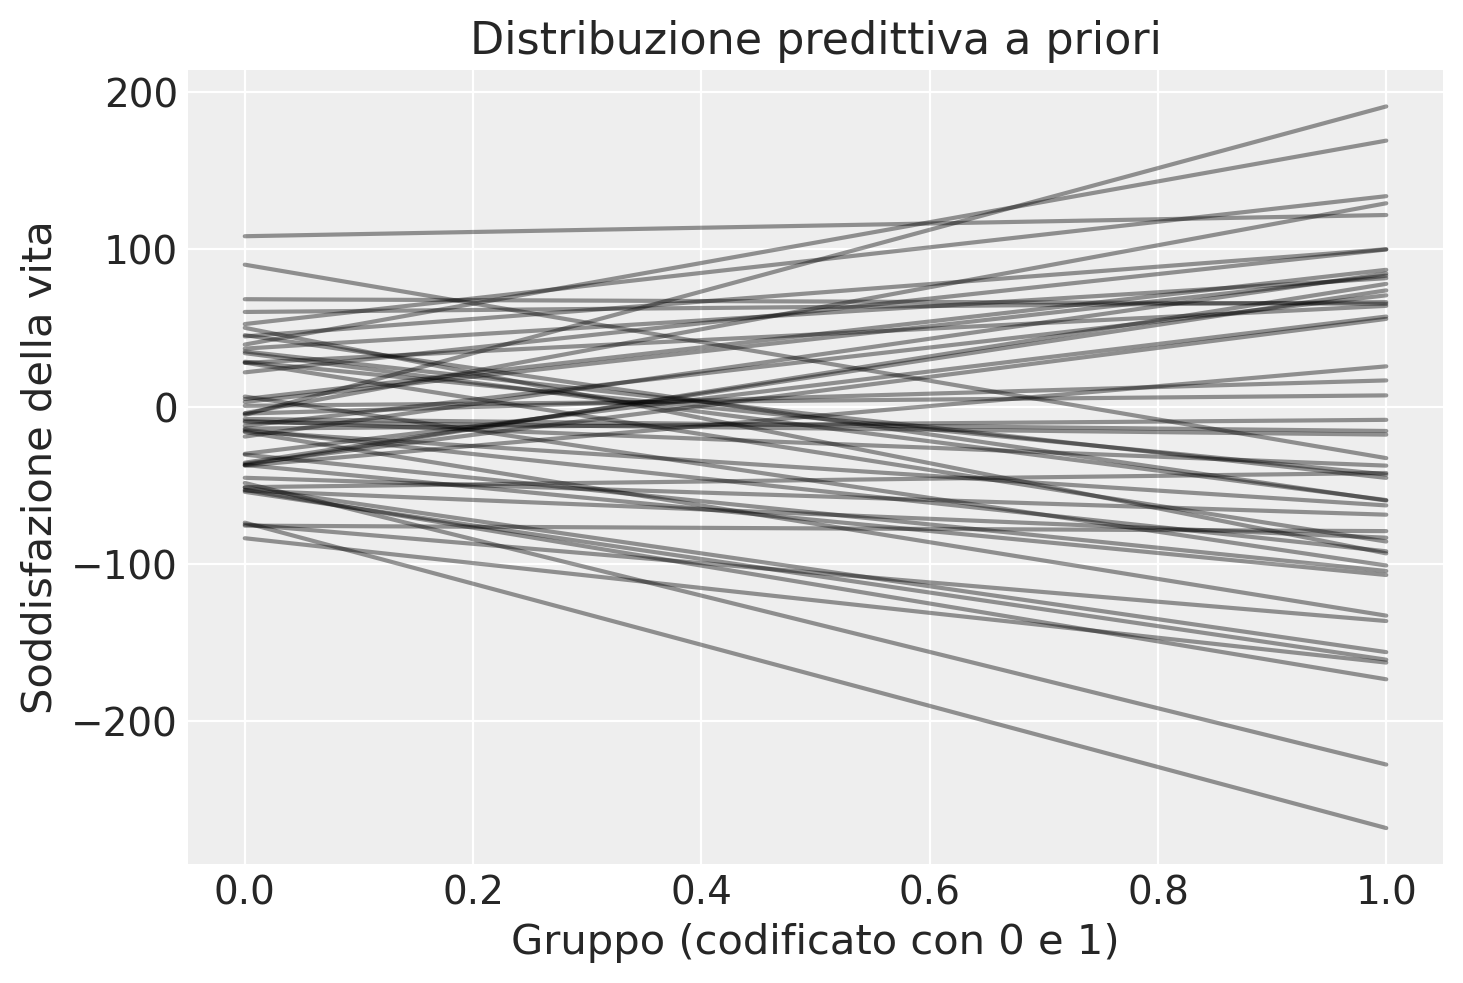

In [27]:
_, ax = plt.subplots()

xp = xr.DataArray(np.linspace(0, 1, 11), dims=["plot_dim"])
prior = idata_p.prior
yp = prior["alpha"] + prior["beta"] * xp

ax.plot(xp, yp.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_ylabel("Soddisfazione della vita")
ax.set_xlabel("Gruppo (codificato con 0 e 1)")
ax.set_title("Distribuzione predittiva a priori");

Si noti che `prior["alpha"]` è un array che contiene 50 valori generati casualmente dal modello per il parametro `alpha`.

In [28]:
prior["alpha"]

<xarray.DataArray 'alpha' (chain: 1, draw: 50)> Size: 400B
array([[ 27.91316336,  -9.761233  ,  21.89391528, -14.56856298,
         68.39580771, -37.42800408, -52.79004685,  90.34566945,
        -53.22280112, -83.55364275,  -5.15598452, -15.56387412,
         35.18040675,  45.55683681,  44.74212001,  52.60001141,
          4.91303814, -13.8408394 , -29.8977839 ,   3.06879684,
         50.20452599,  39.56802222,  28.65514305,  -7.73157439,
        -18.9430296 ,  -4.08430141, -48.42185103, -36.97779067,
         34.10768708, -51.30605918,  -4.31841036, -30.40509399,
        -36.26374915,  36.98455803, -45.12949691, -37.09592811,
        -35.53336193, -54.06503347, -75.56008329,   6.52612528,
        -73.64141351,  28.0803143 ,  60.28700248, 108.42906955,
        -51.10481884, -74.83993705, -16.03126424,  -8.95153788,
        -12.08582618,   0.62408476]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

Lo stesso si può dire per `beta`.

In [29]:
prior["beta"]

<xarray.DataArray 'beta' (chain: 1, draw: 50)> Size: 400B
array([[  36.25169578,   -7.92409658,   78.11662091,  -77.30445403,
          -2.91861005,   63.14901963, -120.4458863 , -122.9803336 ,
         -29.99397584,  -79.06934517,  196.1112678 ,  -47.14082206,
         -80.37696349, -105.18911559,   55.41040452,   81.30111272,
          82.17672831,    5.54854267,   87.26233082,   80.28598144,
        -143.41337086,  129.64063429,  -71.67569728,   -7.63877719,
         103.65954504,  133.47888441, -179.02868192,  -69.95843954,
         -93.39842188, -104.65997079,   21.09319786,  -73.99700599,
          92.13556843,   44.7699911 ,  -23.466116  ,  115.23595245,
         109.53955429, -106.70959991,   -3.47936206, -107.42657989,
        -194.18473598, -113.7431577 ,    6.26294595,   13.49018829,
           9.02114705,  -61.35179689, -116.75047565,  -28.45809619,
          82.9444729 ,    6.62830301]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

L'array `xp` è un vettore unidimensionale di 11 elementi compresi tra 0 e 1.

In [30]:
xp.shape

(11,)

In [31]:
xp

<xarray.DataArray (plot_dim: 11)> Size: 88B
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])
Dimensions without coordinates: plot_dim

Si noti che l'xarray `yp` ha coordinate `chain` e `draw`.

In [32]:
yp

<xarray.DataArray (chain: 1, draw: 50, plot_dim: 11)> Size: 4kB
array([[[ 2.79131634e+01,  3.15383329e+01,  3.51635025e+01,
          3.87886721e+01,  4.24138417e+01,  4.60390112e+01,
          4.96641808e+01,  5.32893504e+01,  5.69145200e+01,
          6.05396896e+01,  6.41648591e+01],
        [-9.76123300e+00, -1.05536427e+01, -1.13460523e+01,
         -1.21384620e+01, -1.29308716e+01, -1.37232813e+01,
         -1.45156910e+01, -1.53081006e+01, -1.61005103e+01,
         -1.68929199e+01, -1.76853296e+01],
        [ 2.18939153e+01,  2.97055774e+01,  3.75172395e+01,
          4.53289016e+01,  5.31405636e+01,  6.09522257e+01,
          6.87638878e+01,  7.65755499e+01,  8.43872120e+01,
          9.21988741e+01,  1.00010536e+02],
        [-1.45685630e+01, -2.22990084e+01, -3.00294538e+01,
         -3.77598992e+01, -4.54903446e+01, -5.32207900e+01,
         -6.09512354e+01, -6.86816808e+01, -7.64121262e+01,
         -8.41425716e+01, -9.18730170e+01],
        [ 6.83958077e+01,  6.81039467e+01,  6.78120857e+01,
          6.75202247e+01,  6.72283637e+01,  6.69365027e+01,
          6.66446417e+01,  6.63527807e+01,  6.60609197e+01,
          6.57690587e+01,  6.54771977e+01],
...
        [-7.48399371e+01, -8.09751167e+01, -8.71102964e+01,
         -9.32454761e+01, -9.93806558e+01, -1.05515835e+02,
         -1.11651015e+02, -1.17786195e+02, -1.23921375e+02,
         -1.30056554e+02, -1.36191734e+02],
        [-1.60312642e+01, -2.77063118e+01, -3.93813594e+01,
         -5.10564069e+01, -6.27314545e+01, -7.44065021e+01,
         -8.60815496e+01, -9.77565972e+01, -1.09431645e+02,
         -1.21106692e+02, -1.32781740e+02],
        [-8.95153788e+00, -1.17973475e+01, -1.46431571e+01,
         -1.74889667e+01, -2.03347764e+01, -2.31805860e+01,
         -2.60263956e+01, -2.88722052e+01, -3.17180148e+01,
         -3.45638245e+01, -3.74096341e+01],
        [-1.20858262e+01, -3.79137889e+00,  4.50306840e+00,
          1.27975157e+01,  2.10919630e+01,  2.93864103e+01,
          3.76808576e+01,  4.59753048e+01,  5.42697521e+01,
          6.25641994e+01,  7.08586467e+01],
        [ 6.24084763e-01,  1.28691506e+00,  1.94974537e+00,
          2.61257567e+00,  3.27540597e+00,  3.93823627e+00,
          4.60106657e+00,  5.26389687e+00,  5.92672717e+00,
          6.58955747e+00,  7.25238777e+00]]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: plot_dim

L'istruzione `yp = prior["alpha"] + prior["beta"] * xp` genera i valori `y` per una serie di rette con coefficienti `prior["alpha"]` e `prior["beta"]`. Nel nostro caso, stiamo generando 50 rette perché abbiamo selezionato 50 valori di `alpha` e 50 valori di `beta` dalle distribuzioni a posteriori.

Nel contesto della modellazione bayesiana, il termine "chain" si riferisce alla catena di campionamento di Markov Monte Carlo (MCMC). Durante il processo di campionamento, vengono eseguiti diversi passaggi successivi per ottenere campioni indipendenti dalla distribuzione a posteriori. Ogni passaggio viene chiamato "draw" o "sample". Pertanto, "chain" rappresenta le catene di campionamento e "draw" rappresenta i singoli campioni all'interno di ciascuna catena.

L'istruzione `yp.stack(sample=("chain", "draw"))` viene utilizzata per combinare le dimensioni "chain" e "draw" al fine di ottenere un array multidimensionale che rappresenta i campioni di parametri estratti dalla distribuzione a posteriori. Ciò facilita la visualizzazione e l'analisi dei campioni.

Notiamo che le pendenze delle rette di regressione generate casualmente dal modello, utilizzando le distribuzioni a priori specificate, presentano un intervallo più ampio rispetto alle pendenze trovate nel campione osservato. Inoltre, il valore medio della variabile dipendente $y$ nel campione è incluso nella distribuzione a priori. Questo suggerisce che le scelte delle distribuzioni a priori siano appropriate per il modello.

Avendo determinato le distribuzioni a priori, eseguiamo il campionamento MCMC.

In [33]:
with Model() as model:

    # Priors
    alpha = Normal("alpha", mu=0, sigma=50)
    beta = Normal("beta", mu=0, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=50)

    # Expected value of outcome
    mu = alpha + beta * x

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Esaminiamo le distribuzioni a posteriori dei parametri.

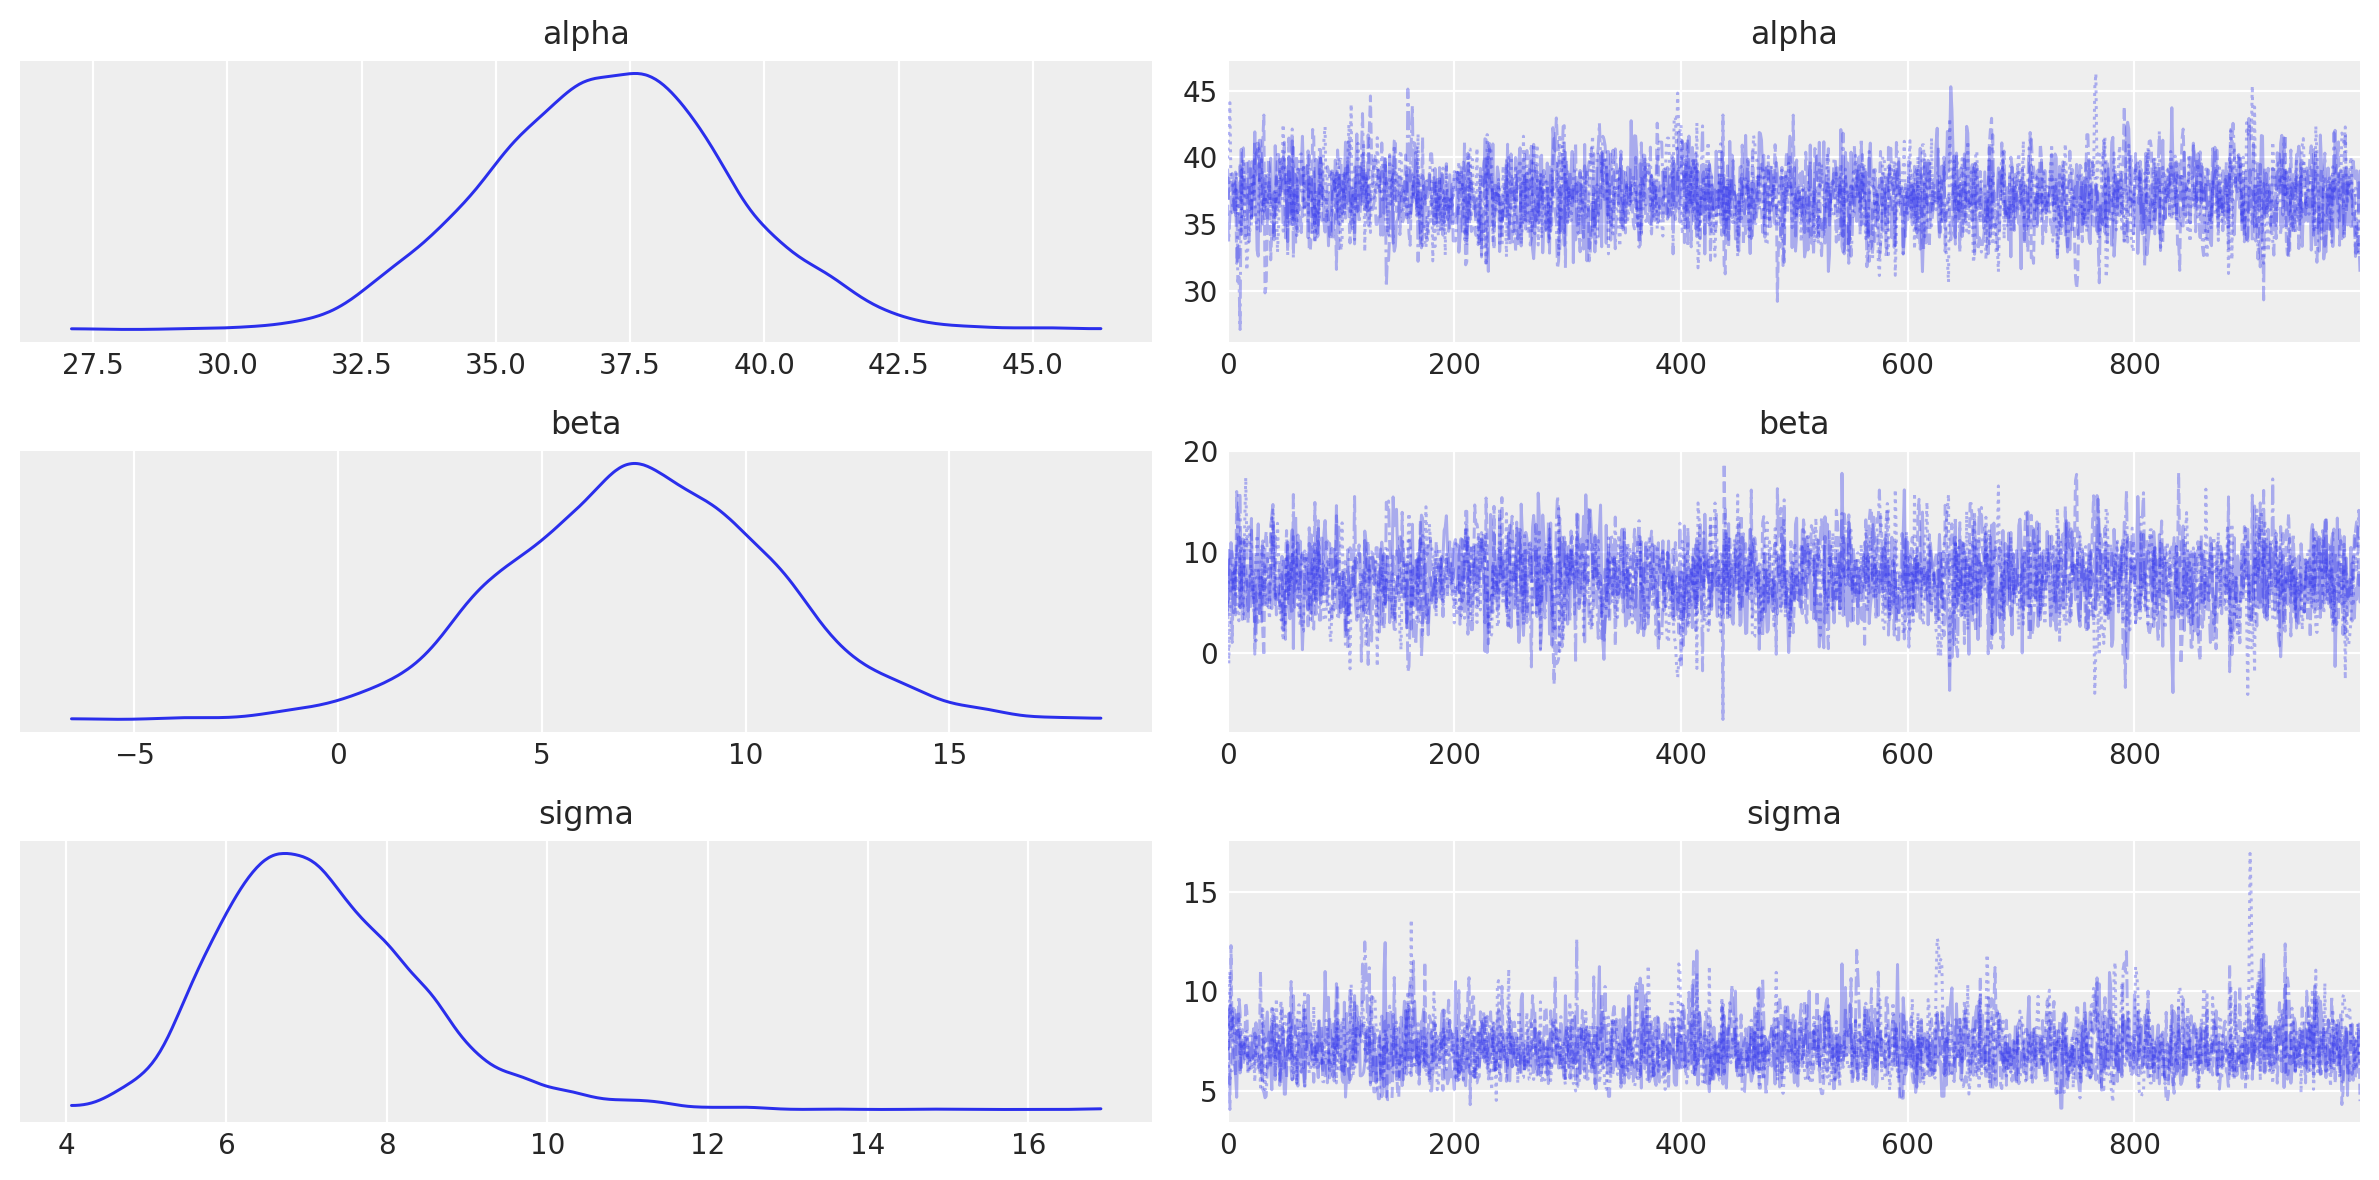

In [34]:
_ = az.plot_trace(idata, combined=True)
plt.tight_layout()

Nel contesto di un modello di regressione in cui i gruppi "older" e "younger" sono codificati rispettivamente come 0 e 1, la media del gruppo "older" può essere interpretata come il valore di riferimento o l'intercetta del modello. In termini matematici, la media del gruppo "older" corrisponde al coefficiente α (alpha) del modello di regressione. La differenza tra le medie dei due gruppi è invece uguale al coefficiente `beta`. 

Per verificare, troviamo la media del gruppo "older" (codificato con x = 0).

In [35]:
np.mean(older)

37.1

Calcoliamo la differenza tra le medie dei due campioni. 

In [36]:
np.mean(younger) - np.mean(older)

7.399999999999999

Esaminiamo ora le stime a posteriori dei due coefficienti del modello e gli intervalli di credibilità al 95%.

In [37]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.067,2.260,32.572,41.284,0.048,0.034,2210.0,2191.0,1.0
beta,7.406,3.250,1.230,14.012,0.070,0.050,2142.0,2151.0,1.0
sigma,7.178,1.278,4.916,9.771,0.028,0.020,2183.0,2007.0,1.0


I coefficienti `alpha` e `beta` nel modello di regressione assumono i valori previsti. L'intervallo di credibilità per il coefficiente `beta` può essere interpretato nel seguente modo: si può affermare con una certezza soggettiva del 95% che il gruppo "younger" tende ad avere una soddisfazione della vita che è almeno 1.1 punti superiore e non più di 14.1 punti superiore rispetto al gruppo "older".


Usiamo ora la funzione dedicata di PyMC per campionare le distribuzioni a posteriori per generare il posterior predictive check. La funzione `sample_posterior_predictive` estrarrà casualmente 40000 campioni dei parametri del modello dalla traccia MCMC. Successivamente, per ogni campione, verranno estratti 100 numeri casuali da una distribuzione normale specificata dai valori di mu e sigma in quel campione:

In [38]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [Y_obs]


Output()

L'oggetto xarray "posterior_predictive" in "idata" conterrà ora 40000 insiemi di dati (ciascuno contenente 100 valori), i quali sono stati generati utilizzando una diversa configurazione dei parametri dalle distribuzioni a posteriori di `alpha` e `beta`:

In [39]:
idata.posterior_predictive

<xarray.Dataset> Size: 648kB
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 20)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 160B 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 640kB 56.93 45.38 ... 29.89
Attributes:
    created_at:                 2024-05-07T04:19:22.885544+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.14.0

Possiamo utilizzare questi dati per verificare se il modello è in grado di riprodurre le caratteristiche osservate nel campione. Per fare ciò, possiamo utilizzare la funzione `plot_ppc` fornita da ArviZ:

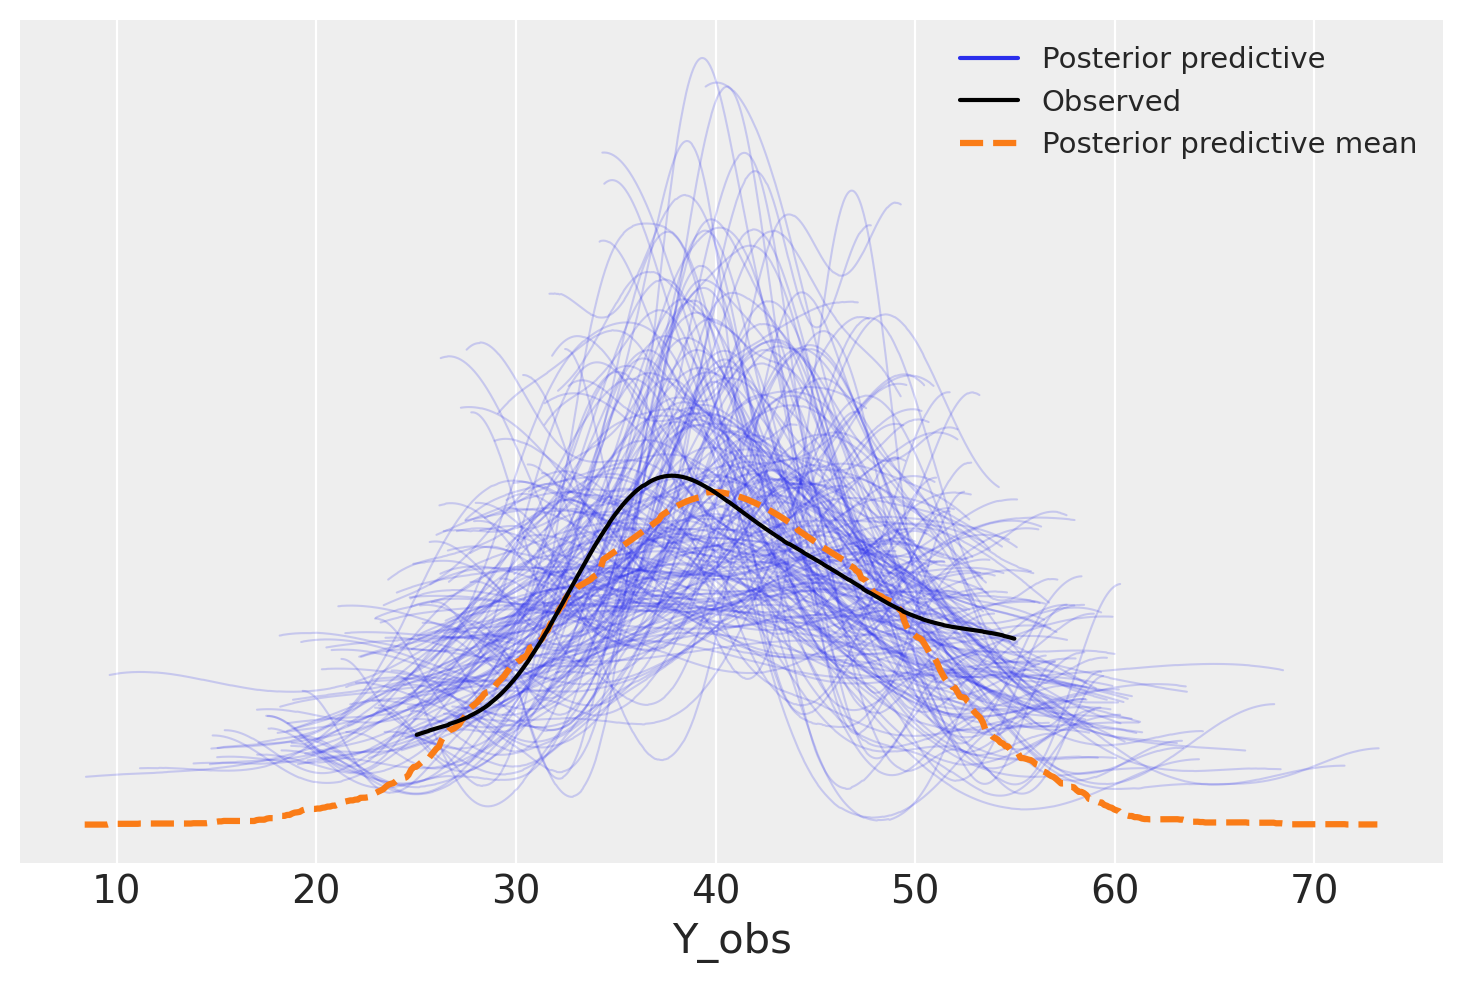

In [40]:
az.plot_ppc(idata, num_pp_samples=200);

Osserviamo che i dati generati dal modello seguono l'andamento dei dati osservati, indicando che il modello è adeguato per i dati considerati. Inoltre, notiamo che il modello produce campioni di dati molto diversi tra loro. Questa variazione è coerente considerando che il campione osservato era di dimensioni ridotte e quindi vi è un'ampia incertezza associata alle caratteristiche dei campioni futuri.

Eseguiamo ora l'analisi di regressione sugli stessi dati usando il metodo dei minimi quadrati. A questo fine usiamo la funzione `linear_regression` del modulo `pingouin`.

In [41]:
pg.linear_regression(df['x'], df['y'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,37.1,2.110029,17.582697,8.790692e-13,0.25465,0.213242,32.666994,41.533006
1,x,7.4,2.984032,2.479867,2.326024e-02,0.25465,0.213242,1.130782,13.669218


La stima dei coefficienti è altamente coerente con quella ottenuta utilizzando PyMC. L'intervallo di fiducia per il coefficiente `b`, che rappresenta la differenza tra le medie dei due gruppi, presenta una somiglianza notevole con l'intervallo di credibilità bayesiano.

Tuttavia, è importante sottolineare che, anche se in questo caso specifico l'approccio frequentista produce risultati simili all'approccio bayesiano, non è possibile generalizzare questa conclusione a tutti i casi. Le differenze tra i due approcci possono emergere in scenari diversi e richiedono un'analisi caso per caso.

## Project Star

Svolgiamo ora un altro esercizio usando dei dati reali relativi al progetto Star. Il Project STAR (Student-Teacher Achievement Ratio) è stato un grande esperimento educativo condotto negli Stati Uniti tra il 1985 e il 1990. L'obiettivo era quello di esaminare l'effetto della dimensione delle classi sulla performance degli studenti. In particolare, gli studenti venivano assegnati in modo casuale a classi di piccole dimensioni (13-17 studenti) o grandi dimensioni (22-25 studenti).

Il progetto coinvolse più di 6.000 studenti e 1.000 insegnanti in 79 scuole elementari in Tennessee. I risultati dello studio indicarono che gli studenti assegnati a classi più piccole hanno ottenuto risultati migliori in termini di performance accademica, partecipazione in classe, comportamento e assenze rispetto agli studenti assegnati a classi più grandi.

In questo capitolo, analizziamo una parte dei dati del Project STAR. Come variabili abbiamo i punteggi ottenuti dagli studenti ai test standardizzati di lettura e matematica alla fine del terzo anno, insieme alla percentuale di studenti che hanno completato gli studi superiori.

L'obiettivo dell'esercizio è calcolare la media dell'effetto causale della frequenza delle classi piccole rispetto alle classi di dimensioni standard sui punteggi dei test di lettura di terza elementare per tutta la popolazione target di studenti.

Leggiamo i dati dal file `STAR.csv`.

In [43]:
df_star = pd.read_csv("../data/STAR.csv")
df_star.head()

,classtype,reading,math,graduated
0,small,578,610,1
1,regular,612,612,1
2,regular,583,606,1
3,small,661,648,1
4,small,614,636,1


Le medie dei due gruppi sono le seguenti.

In [44]:
group_means = df_star.groupby('classtype')["reading"].mean()
print(group_means)

classtype
regular    625.492017
small      632.702564
Name: reading, dtype: float64


Generiamo un violin plot per i punteggi nel test di lettura di terza elementare per i due gruppi.

<Axes: xlabel='classtype', ylabel='reading'>

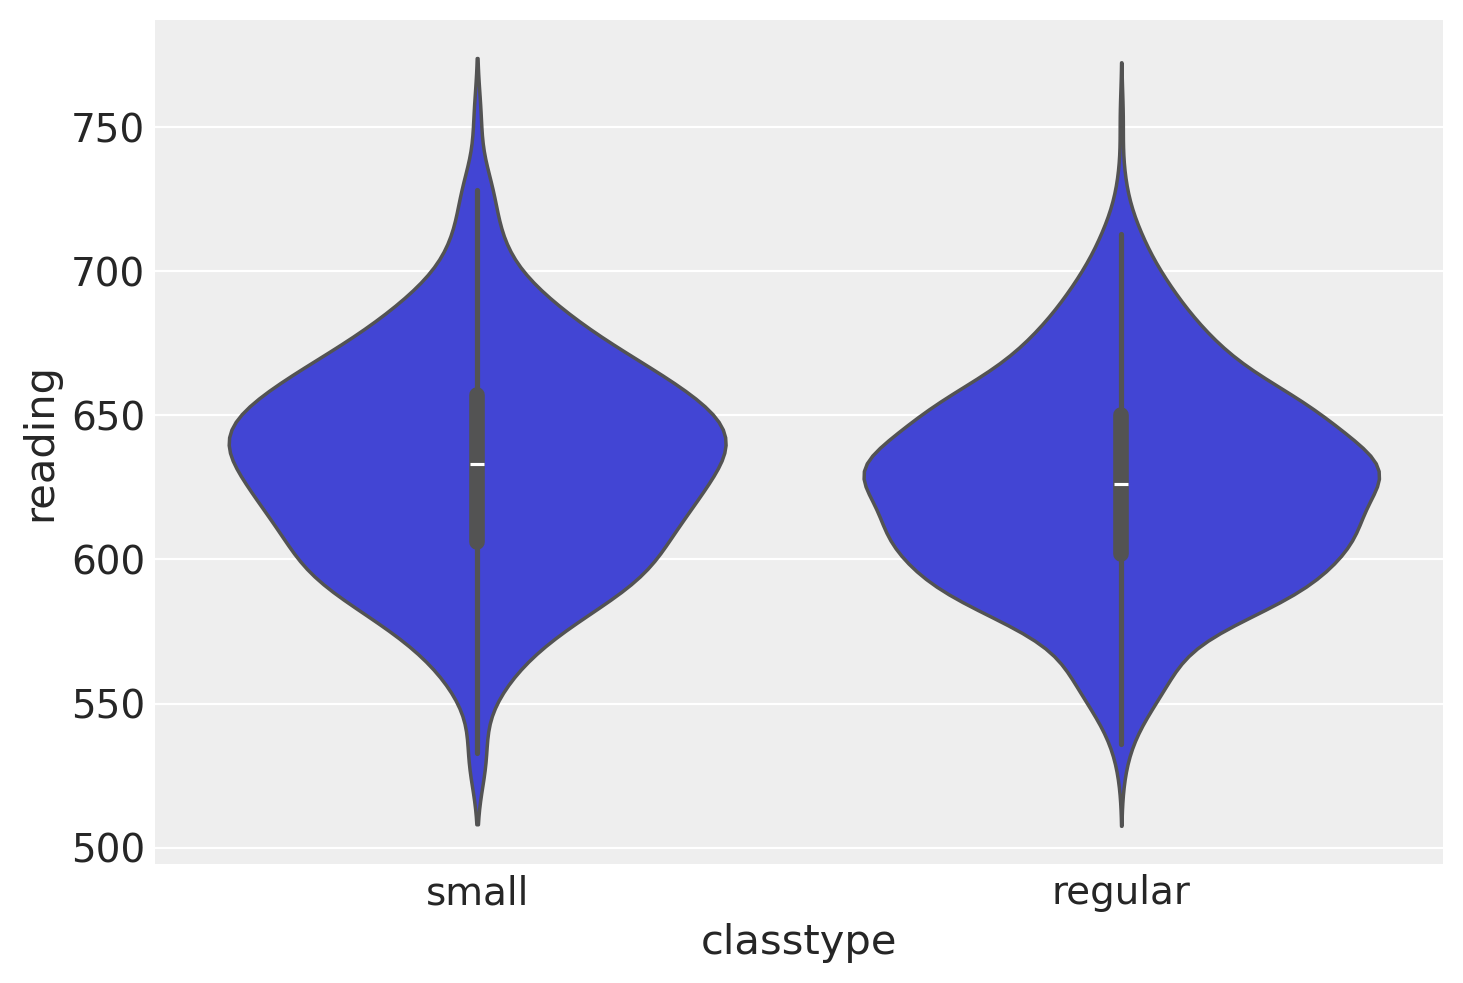

In [45]:
sns.violinplot(x="classtype", y="reading", data=df_star)

L'ipotesi nulla è che i dati provengono da due popolazioni aventi la stessa media: $H_0: \mu_1 - \mu_2 = 0$. Useremo un test bilaterale, ovvero rifiuteremo $H_0$ sia quando il valore $T$ cade nella regione di rifiuto perché $\mu_1 > \mu_2 = 0$, sia quando cade nella regione di rifiuto perché $\mu_1 < \mu_2 = 0$.

Per semplicità, credo due DataFrame, uno per ciascun gruppo.

In [46]:
df_small = df_star[df_star['classtype'] == 'small']
df_regular = df_star[df_star['classtype'] == 'regular']

Svolgo il test $t$ di Student per due gruppi indipendenti con la funzione `ttest`.

In [47]:
res = pg.ttest(df_small["reading"], df_regular["reading"], paired=False)
print(res)

               T          dof alternative    p-val          CI95%   cohen-d  \
T-test  3.495654  1220.993525   two-sided  0.00049  [3.16, 11.26]  0.197183   

          BF10     power  
T-test  25.771  0.938789  


**Interpretazione.** Avendo ottenuto un valore-p minore di $\alpha$, si conclude rifiutando l'ipotesi nulla di uguaglianza delle due medie. Si presti però attenzione al $d$ di Cohen: $d$ = 0.20. Ciò significa che la dimensione dell'effetto è piccola.

Svolgiamo ora i calcoli passo-passo. Calcoliamo la differenza tra le medie dei due gruppi.

In [48]:
mean_diff = np.mean(df_small["reading"]) - np.mean(df_regular["reading"])
mean_diff

7.210546686018347

Troviamo i gradi di libertà per la differenza tra due medie indipendenti.

In [49]:
num_rows = df_star.shape[0]
num_rows

1274

In [50]:
dof = 2 * num_rows - 2
dof

2546

Troviamo il valore critico per un test bilaterale.

In [51]:
t_c = st.t.ppf(0.975, dof)
t_c

1.9608961841574426

Se non assumiamo che le due varianze siano uguali, allora l'errore standard per la differenza tra le medie di due gruppi indipendenti è

$$
\sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}.
$$

In [52]:
se_diff = np.sqrt(
    np.var(df_small["reading"], ddof=1) / len(df_small["reading"]) +
    np.var(df_regular["reading"], ddof=1) / len(df_regular["reading"])
    )
se_diff

2.0627173626882493

Troviamo il valore della statistica $T$.

In [53]:
T = mean_diff / se_diff
print(T)

3.4956542357413216


Troviamo il valore-p.

In [54]:
(1 - st.t.cdf(T, df=dof)) * 2

0.0004809856733483109

Calcoliamo ora l'intervallo di fiducia al 95% per la differenza tra le medie dei due gruppi:

$$
(\bar{X}_1 - \bar{X}_2) \pm t_{n_1 + n_2 - 2} \cdot \sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}.
$$

In [55]:
pm = np.array([-1, +1])
ci = mean_diff + pm * (t_c * se_diff)
print(ci)

[ 3.16577208 11.25532129]


**Interpretazione.** Dai risultati ottenuti, si può concludere che l'effetto causale medio di frequentare una classe piccola sui punteggi dei test di lettura di terza elementare, per tutti gli studenti della popolazione target, è probabilmente un aumento compreso tra 3.17 e 11.25 punti.

### Margine d'errore

Esiste un modo alternativo di esprimere gli intervalli di confidenza, che è popolare nel mondo dei sondaggi. Coinvolge l'uso di ciò che è noto come "margine di errore", definito come la metà della larghezza dell'intervallo di confidenza. Utilizzando questo termine, possiamo esprimere l'intervallo di confidenza come: 

$$
\text{stimatore} \pm \text{margine di errore.} 
$$

Per i dati presenti, possiamo dire che frequentare una classe piccola produce un incremento atteso di 7.21 ± 4.04 punti sui punteggi dei test di lettura di terza elementare. L'ampiezza dell'intervallo di confidenza è qui di 8.08 punti, quindi il margine di errore è di 4.04 punti. 

Si deve notare la differenza concettuale tra il risultato espresso in termini di intervallo di confidenza o margine d'errore, che rappresenta una differenza *assoluta* tra le medie dei due gruppi, e l'indice $d$ di Cohen, il quale rappresenta una differenza *relativa* tra le medie dei due gruppi, ponderata in base all'incertezza della stima. In altre parole, mentre il margine d'errore esprime la precisione della stima assoluta della differenza tra le medie, l'indice $d$ di Cohen esprime la dimensione dell'effetto relativo tra i due gruppi, tenendo conto della variazione naturale dei dati.

## Inferenza su una proporzione

Occupiamoci ora dell'inferenza sulla proporzione di una popolazione. La teoria delle probabilità ci dice che il valore atteso della proporzione campionaria $\hat{p}$ è la proporzione $p$ della popolazione e che la deviazione standard della proporzione campionaria è la deviazione standard della variabile casuale binomiale $Y$ divisa per $n$:

$$\begin{align}
\mu_{\hat p}&=\frac{\mu_Y}{n} = p \\
\sigma_{\hat p} &=\frac{\sigma_Y}{n} = \frac{\sqrt{n \cdot p \cdot (1-p)}}{n} = \sqrt{\frac{p \cdot (1-p)}{n}}
\end{align}$$

Questo punto può essere chiarito da una simulazione. Supponiamo di esaminare 10000 campioni casuali di ampiezza 10 estratti da una popolazione nella quale la probabilità di "successo" è 0.6.

In [56]:
p = 0.6
n = 10
X = st.bernoulli(p)
Y = [X.rvs(n) for i in range(10000)]

I primi 5 campioni sono i seguenti.

In [57]:
Y[0:5]

[array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1]),
 array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1]),
 array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])]

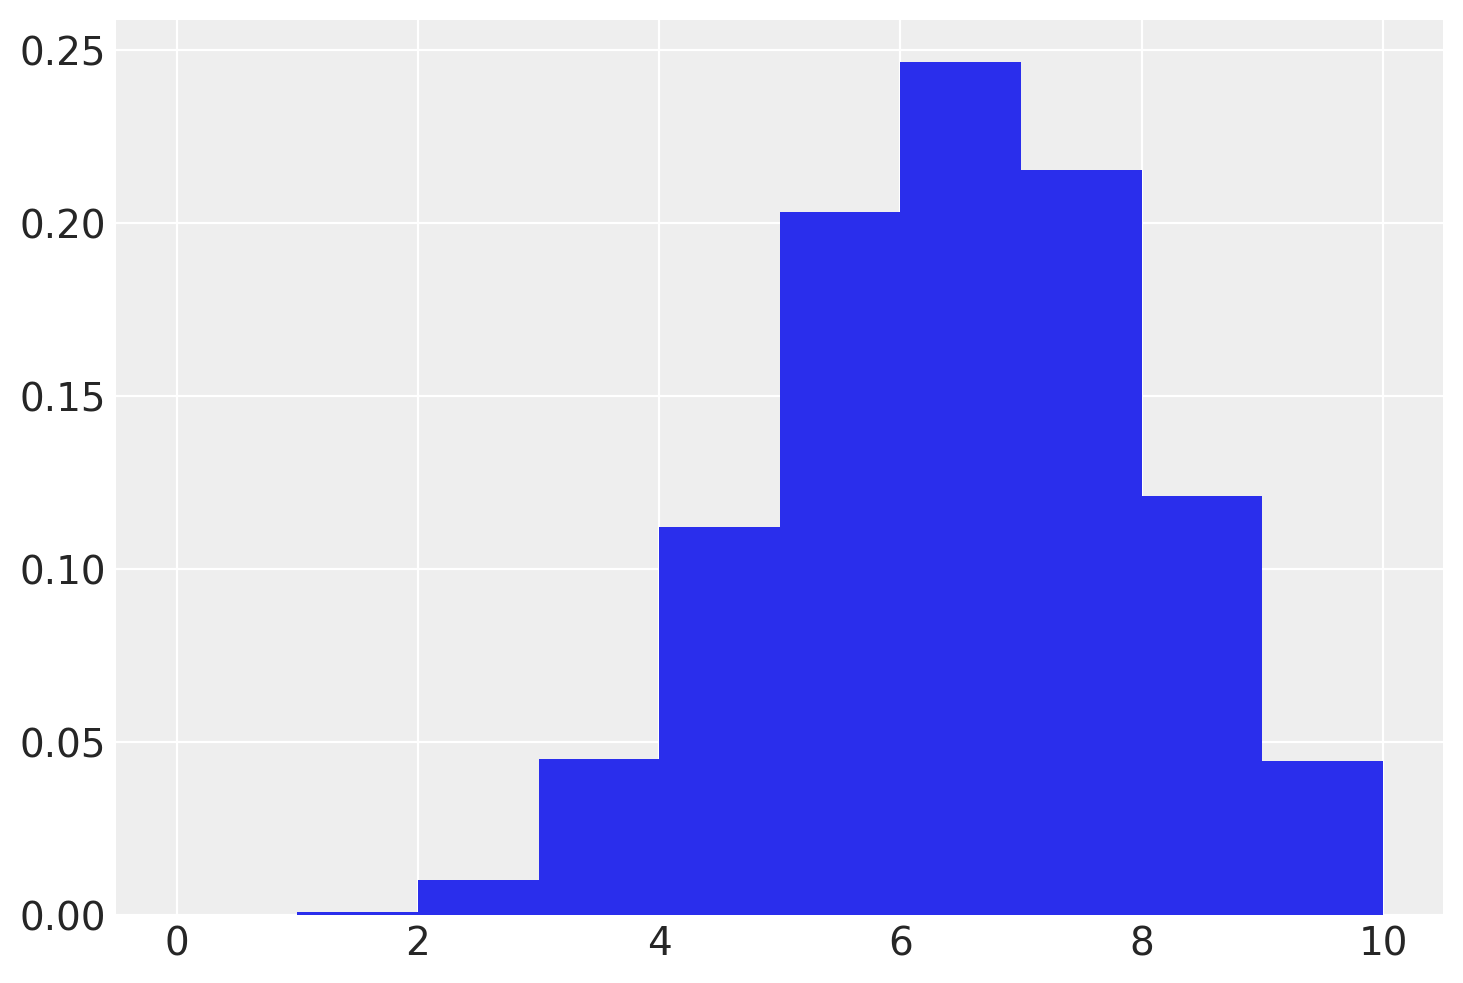

In [58]:
_ = plt.hist(np.sum(Y, axis=1), density=True)

L'istogramma precedente è un'approssimazione empirica della distribuzione delle proporzioni campionarie di ampiezza 10 estratte da una popolazione con probabilità di successo uguale a 0.6.

In [59]:
print('Media empirica della distribuzione campionaria: {}'.format(np.mean(np.mean(Y, axis=1))))
print('Valore teorico atteso: {}'.format(p))

Media empirica della distribuzione campionaria: 0.5986799999999999
Valore teorico atteso: 0.6


In [60]:
print('Stima empirica della deviazione standard: {}'.format(np.std(np.mean(Y, axis=1))))
print('Deviazione standard teorica: {}'.format(np.sqrt(p*(1-p)/n)))

Stima empirica della deviazione standard: 0.154939528849161
Deviazione standard teorica: 0.15491933384829668


Man mano che aumenta il numero di campioni estratti dalla popolazione, i due valori diventano sempre più simili.

Per quel che riguarda la forma della distribuzione, come conseguenza del TLC possiamo dire che la distribuzione delle proporzioni campionarie tende sempre più ad assumere una forma normale all'aumentare della dimensione dei campioni.

Per mettere alla prova il TLC, consideriamo un caso estremo, ovvero una popolazione nella quale la probabilità di successo è 0.03. Supponiamo che la numerosità campionaria sia uguale a 400.

In [61]:
p = 0.03
n = 400
X = st.bernoulli(p)
Y = [X.rvs(n) for i in range(10000)]

In [62]:
print('Media empirica della distribuzione campionaria: {}'.format(np.mean(np.mean(Y, axis=1))))
print('Valore teorico atteso: {}'.format(p))

Media empirica della distribuzione campionaria: 0.029917250000000003
Valore teorico atteso: 0.03


In [63]:
print('Stima empirica della deviazione standard: {}'.format(np.std(np.mean(Y, axis=1))))
print('Deviazione standard teorica: {}'.format(np.sqrt(p*(1-p)/n)))

Stima empirica della deviazione standard: 0.008587201373992577
Deviazione standard teorica: 0.00852936105461599


In [64]:
np.mean(Y, axis=1)

array([0.03  , 0.04  , 0.0275, ..., 0.045 , 0.0325, 0.035 ])

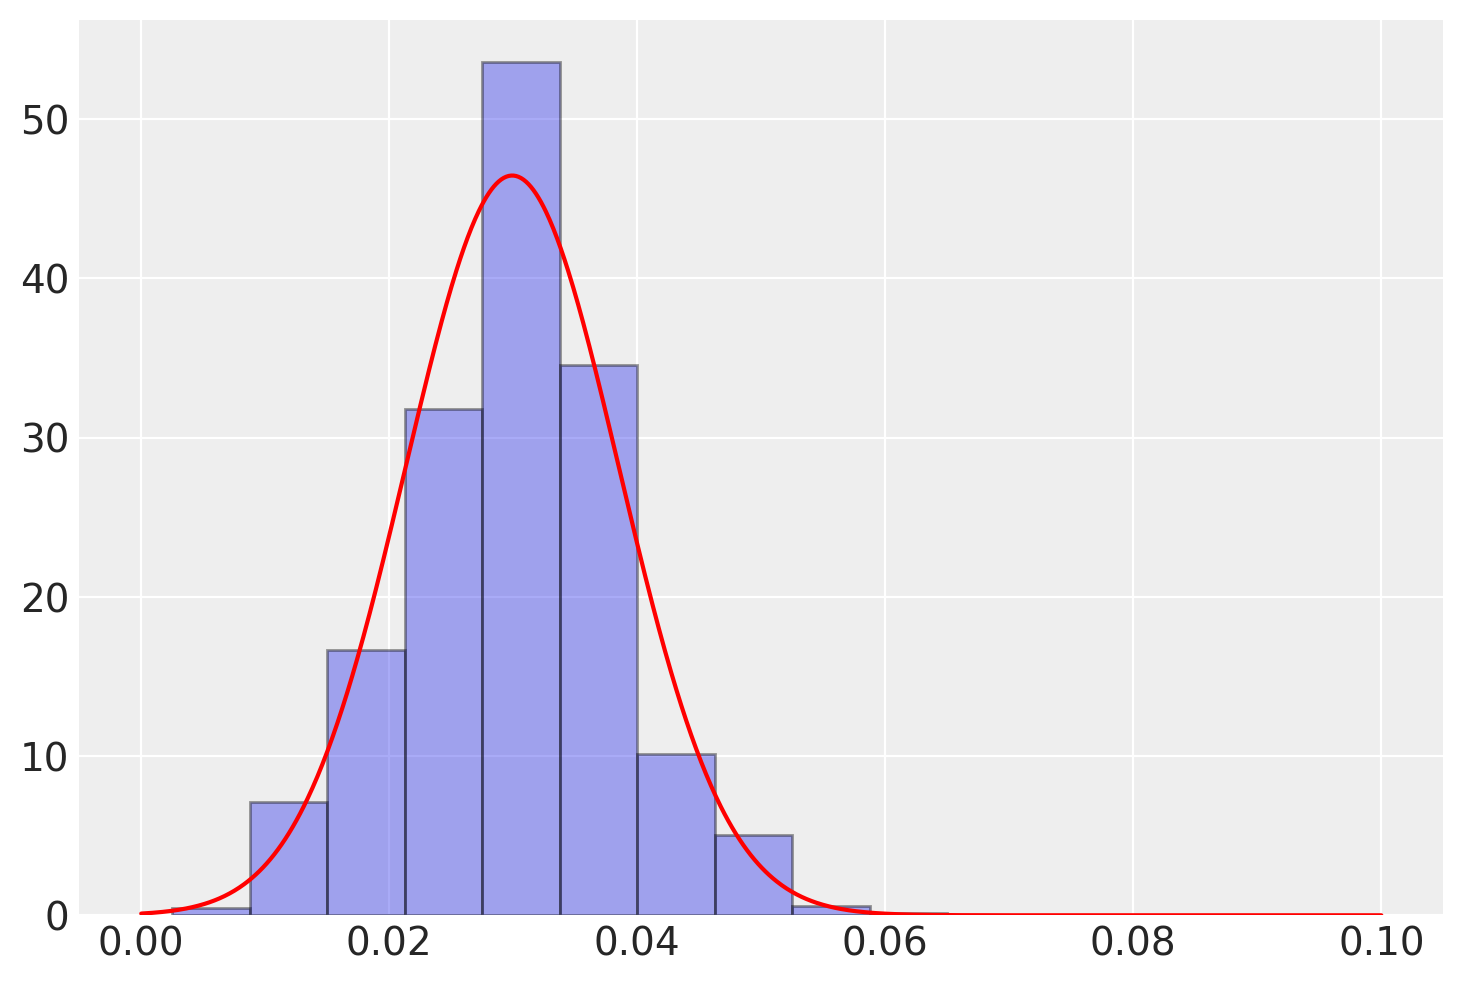

In [65]:
y = np.mean(Y, axis=1)
sns.distplot(y, bins=10, hist=True, kde=False, norm_hist=True, hist_kws={'edgecolor':'black'})
x = np.linspace(0, 0.1, 1000)
y = st.norm.pdf(x, np.mean(y), np.std(y))  # Normal density values
plt.plot(x, y, 'r-', label='Normal Density')

### Brexit

Prendiamo in considerazione un ulteriore relativo all'indagine BES condotta prima del referendum sulla Brexit del 2016 al fine di valutare l'opinione pubblica dell'intera popolazione del Regno Unito. Importiamo i dati.

In [67]:
bes = pd.read_csv("../data/BES.csv")
bes.head()

,vote,leave,education,age
0,leave,1.0,3.0,60
1,leave,1.0,NaN,56
2,stay,0.0,5.0,73
3,leave,1.0,4.0,64
4,don't know,NaN,2.0,68


In [68]:
bes.shape

(30895, 4)

Eliminiamo le righe del DataFrame che contengono dati mancanti.

In [69]:
bes_cleaned = bes.dropna()
bes_cleaned.shape

(25097, 4)

Calcoliamo la proporzione di risposte "leave".

In [70]:
bes_cleaned["leave"].mean()

0.47188907040682154

L'output del sondaggio BES indica che il 47.19% dei partecipanti era a favore della Brexit. Tuttavia, non possiamo inferire da questo risultato che circa il 47% di tutti gli elettori del Regno Unito era a favore della Brexit, poiché si tratta di un risultato a livello di campione. Per generalizzare a livello di popolazione, dobbiamo considerare la variabilità campionaria che introduce rumore nei nostri risultati.

Abbiamo visto sopra che la distribuzione campionaria di una proporzione presenta le seguenti caratteristiche:

- La media della distribuzione campionaria di una proporzione è uguale alla proporzione della popolazione. Ciò significa che in media, la proporzione dei valori del campione è uguale alla proporzione della popolazione.
- La deviazione standard della distribuzione campionaria di una proporzione è calcolata come $\sqrt{\pi (1-\pi) / n}$, dove $\pi$ rappresenta la proporzione della popolazione e $n$ è la dimensione del campione. La deviazione standard rappresenta la dispersione dei valori del campione intorno alla proporzione della popolazione. Possiamo stimare l'errore standard sostituendo $\pi$ con $p$, la proporzione campionaria.
- La distribuzione campionaria di una proporzione tende alla normale se la dimensione del campione è grande.

Per fare inferenze sul parametro $\pi$ della popolazione (la proporzione di elettori del Regno Unito a favore della Brexit nel 2016), possiamo costruire un intervallo di confidenza al 95% per la proporzione nella popolazione.

Per iniziare il calcolo dell'intervallo di confidenza, dobbiamo prima determinare la dimensione del campione.

In [71]:
n = bes_cleaned.shape[0]
n

25097

Possiamo stimare l'errore standard di una proporzione con la formula 
$
SE = \sqrt{p (1-p) / n}.
$

In [72]:
p = bes_cleaned["leave"].mean()
se = np.sqrt(p * (1 - p) / n)
print(se)

0.0031511685382488307


Troviamo il limite inferiore e il limite superiore dell'intervallo di fiducia al 95%.

In [73]:
pm = np.array([-1, +1])
ci = np.mean(bes_cleaned["leave"]) + pm * st.norm.ppf(0.975) * se
print(f"L'intervallo di fiducia al 95% è [{ci[0]:.4f}, {ci[1]:.4f}].")

L'intervallo di fiducia al 95% è [0.4657, 0.4781].


Secondo l'approccio frequentista, è possibile affermare che la proporzione di sostegno per la Brexit tra tutti gli elettori del Regno Unito nel 2016 era compresa con una probabilità del 95% tra il 46.57% e il 47.81%. Questo intervallo di confidenza è stato ottenuto mediante una procedura di stima con un livello di confidenza del 95%, il quale indica la probabilità che l'intervallo contenga il vero valore del parametro.

Inoltre, il margine di errore, che rappresenta la metà della larghezza dell'intervallo di confidenza, è di 0.62 punti percentuali. Ciò significa che la proporzione di sostegno per la Brexit tra tutti gli elettori del Regno Unito nel 2016 era probabilmente del 47.19%, con un margine di errore di 0.62 punti percentuali.

Si noti che il margine di errore dipende dalla dimensione del campione. Nel caso del sondaggio BES, che ha una grande dimensione del campione di 25097 osservazioni, il margine di errore è relativamente piccolo. Tuttavia, per la maggior parte dei sondaggi che hanno una dimensione del campione molto più piccola, di circa 1000 osservazioni, il margine di errore sarà molto più grande. In generale, all'aumentare della dimensione del campione, la larghezza dell'intervallo di confidenza diminuisce, e viceversa.


### Supporto per la Brexit ed età

Con i dati del sondaggio BES facciamo un altro esempio relativo al confronto tra due medie indipendenti. Nello specifico, esamineremo la differenza d'età tra gli elettori che hanno espresso supporto per la Brexit e quelli che invece hanno sostenuto la posizione "stay".


<Axes: xlabel='leave', ylabel='age'>

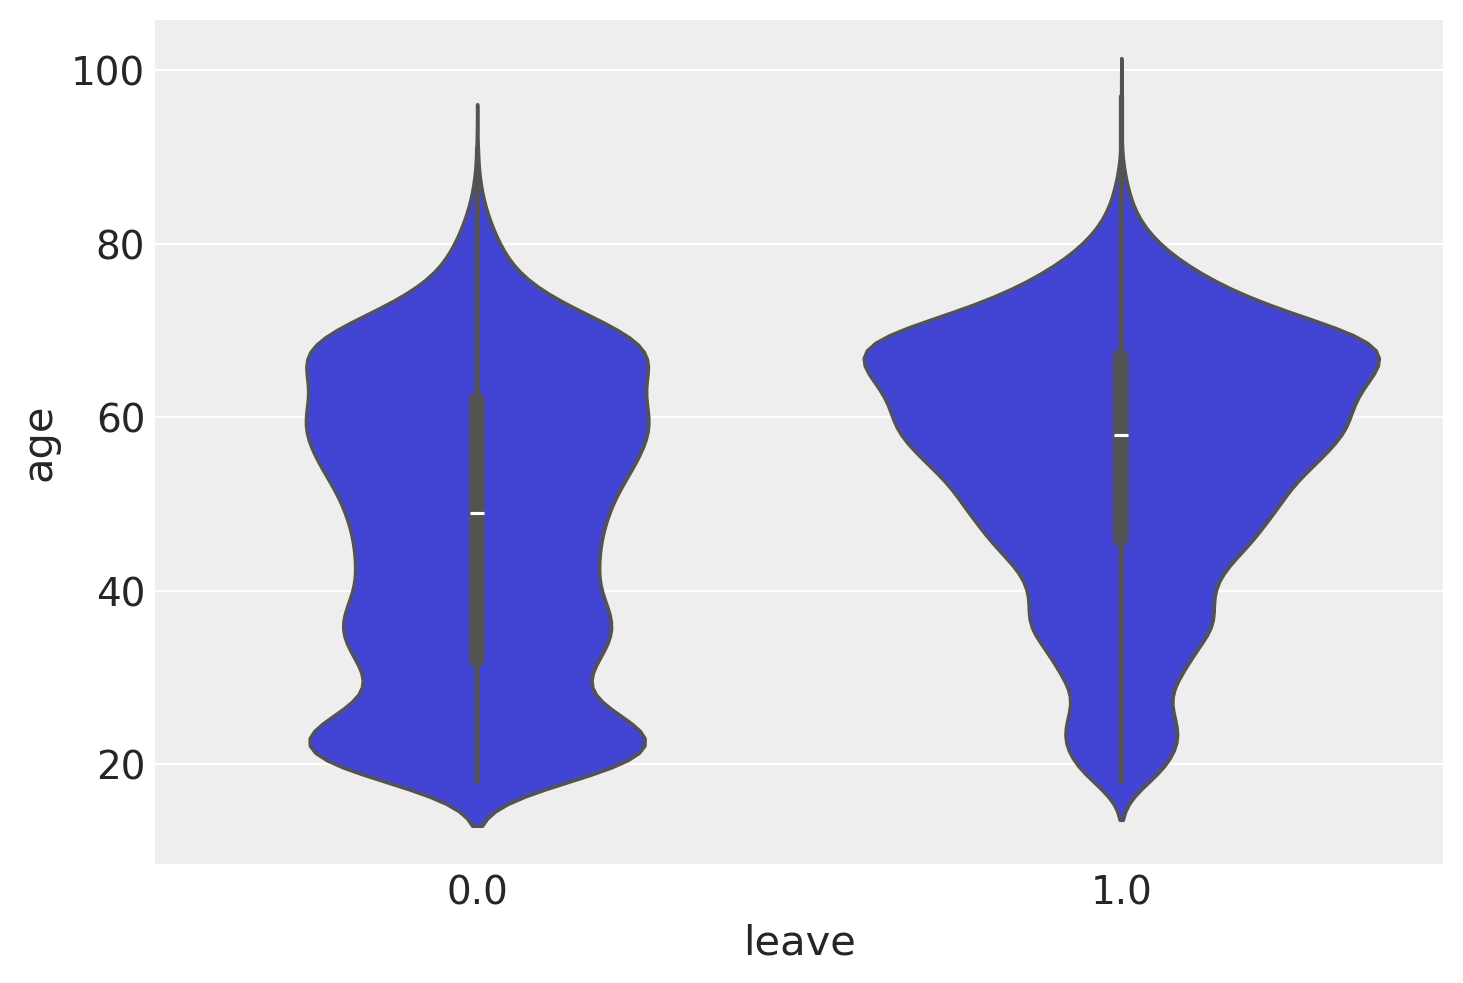

In [74]:
sns.violinplot(x="leave", y="age", data=bes)

Il violin plot rivela che l'età media dei sostenitory della posizione "leave" è più alta dell'età media del gruppo "stay". Si noti però che le due distribuzioni non sembrano gaussiane.

Per verificare l'ipotesi di gaussianità dei dati, usiamo un QQ-plot (Quantile-Quantile plot). Un QQ-plot è uno strumento grafico utilizzato per verificare se una distribuzione di dati segue o meno una distribuzione teorica, come ad esempio una distribuzione normale. In pratica, un QQ-plot confronta i quantili di una distribuzione di dati con quelli di una distribuzione teorica, disegnando un grafico dei quantili teorici lungo l'asse x e dei quantili dei dati lungo l'asse y. Se i dati seguono la distribuzione teorica, allora i punti nel QQ-plot si distribuiranno lungo una linea retta. Se invece ci sono deviazioni dalla distribuzione teorica, i punti nel QQ-plot si discosteranno dalla retta e si potrà individuare in che punto si verificano le maggiori deviazioni.

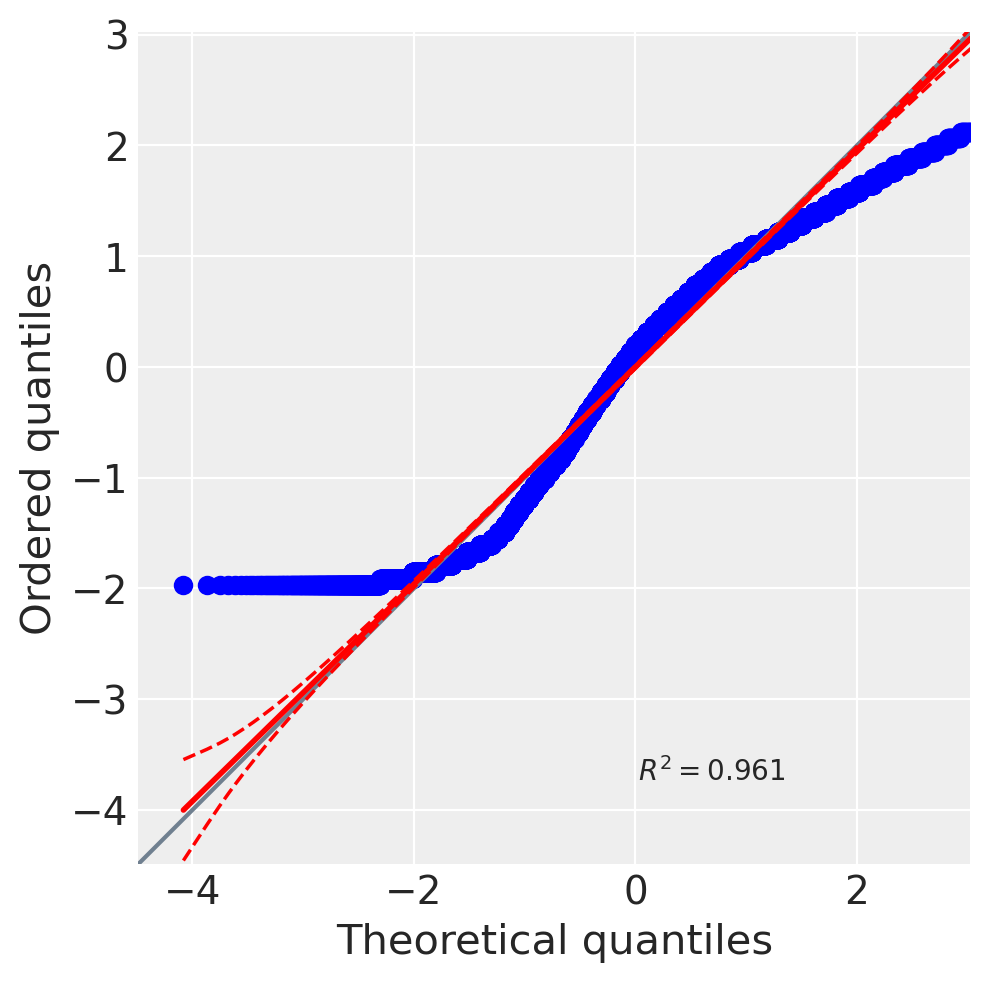

In [75]:
ax = pg.qqplot(bes["age"], dist="norm")

Si può osservare dal QQ-plot che i valori di età estremi della distribuzione differiscono marcatamente dalle corrispondenti aspettative teoriche. Solo per fare un esecizio, proseguiamo comunque con l'analisi dei dati e applichiamo il test t di Student ai due gruppi d'età. Si noti però che, per dati non normali, una tale procedura di analisi statistica è inappropriata. 

Possiamo anche visualizzare i dati dei due gruppi tramite un KDE plot (da notare che questa rappresentazione è già inclusa nel violin plot precedente).

<Axes: xlabel='age', ylabel='Density'>

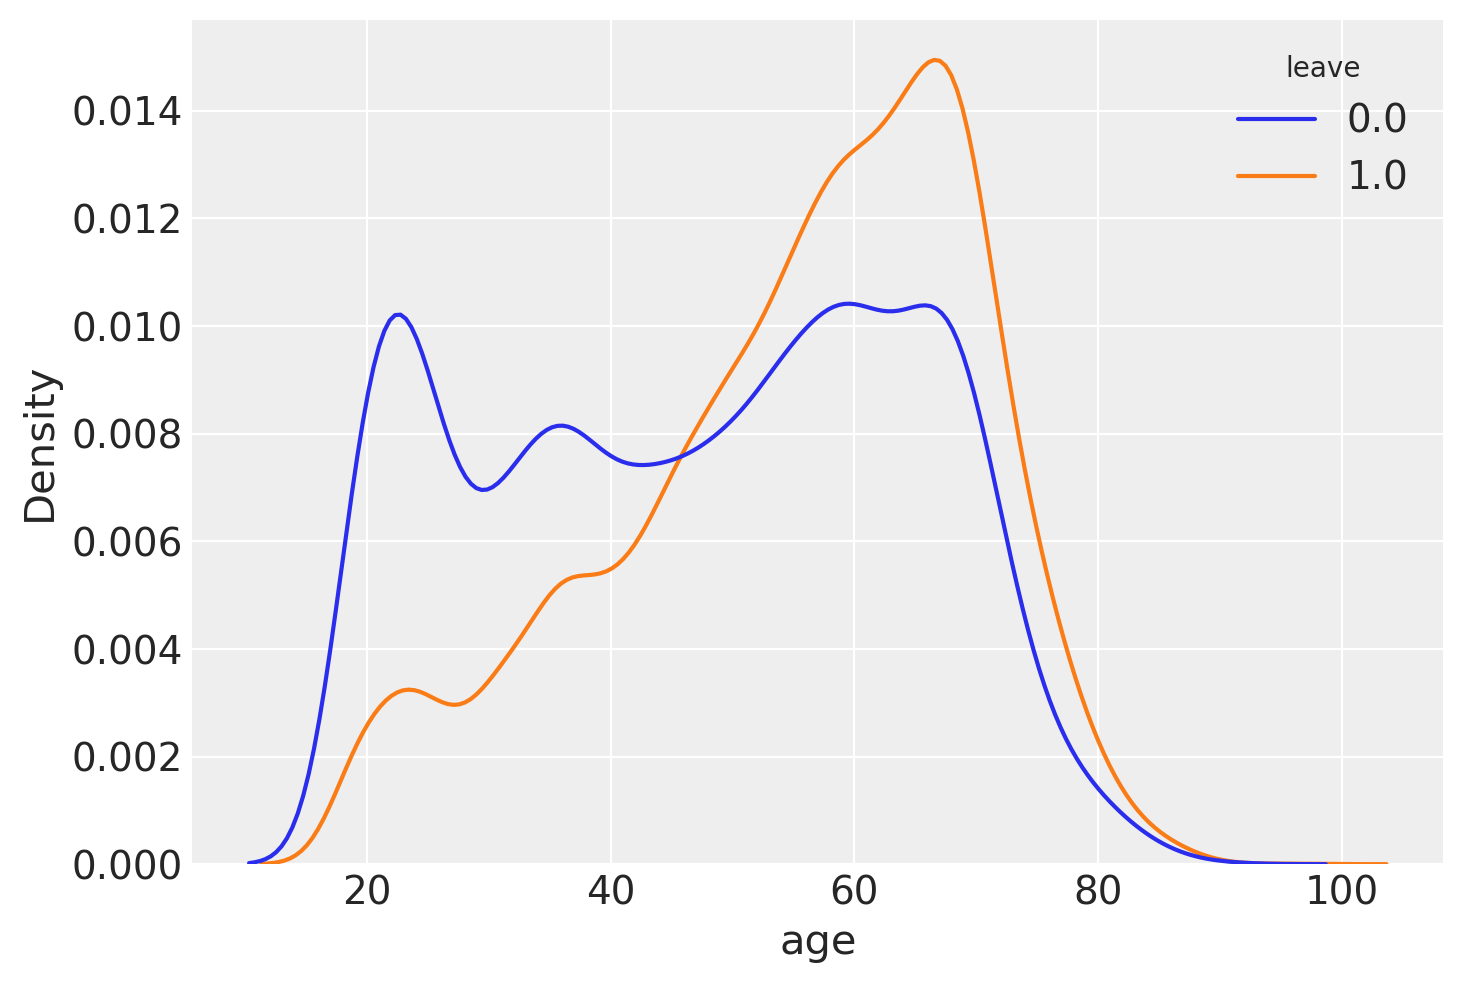

In [76]:
sns.kdeplot(data=bes, x="age", hue="leave")

Per agevolare il test t di Student, dividiamo il DataFrame originale in due DataFrame distinti.

In [77]:
leave_df = bes[bes["leave"] == 1]
stay_df = bes[bes["leave"] == 0]

L'ipotesi nulla che viene sottoposta a verifica con il test t di Student è l'uguaglianza delle medie dei valori dell'età nelle due popolazioni da cui i campioni sono stati estratti: $H_0: \mu_{\text{leave}} = \mu_{\text{stay}}$. Il test t di Student può essere facilmente eseguito utilizzando la funzione `ttest` del pacchetto `pingouin`.

In [78]:
res = pg.ttest(leave_df["age"], stay_df["age"], paired=False)
print(res)

                T           dof alternative  p-val         CI95%   cohen-d  \
T-test  41.588603  27738.840259   two-sided    0.0  [7.63, 8.38]  0.495062   

       BF10  power  
T-test  inf    1.0  


Svolgiamo ora i calcoli applicando la formula del test t di Student. La statistica $t$ di Student per la differenza tra le medie di due campioni indipendenti è

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}},$$

dove $\bar{x}_1$ e $\bar{x}2$ sono le medie dei due campioni, $s^2_1$ e $s^2_2$ sono le varianze dei due campioni e $n_1$ e $n_2$ sono le dimensioni dei due campioni.

In [79]:
n_l = leave_df.shape[0]
n_l

13692

In [80]:
n_s = stay_df.shape[0]
n_s

14352

In [81]:
n_l + n_s - 2

28042

Calcoliamo l'errore standard della differenza delle medie di due campioni indipendenti.

In [82]:
se = np.sqrt(
    (np.var(leave_df["age"], ddof=1) / n_l) + 
    (np.var(stay_df["age"], ddof=1) / n_s)
) 
se

0.19250126816432642

Troviamo la statistica t di Student.

In [83]:
T = (np.mean(leave_df["age"]) - np.mean(stay_df["age"])) / se

Troviamo il valore-p con la funzione `t.sf` che calcola l'area sottesa alla funzione $t$ nella coda di destra. È importante notare che le funzioni Python che abbiamo utilizzato in precedenza calcolano i gradi di libertà in modo diverso rispetto alla formula $n_1+n_2-2$. Infatti, il numero di gradi di libertà calcolato come $n_1+n_2-2$ è appropriato solo quando le varianze delle due popolazioni sono uguali. Se le varianze sono diverse, è necessario introdurre un fattore di correzione, che viene calcolato mediante software. Tuttavia, per questo esercizio, procederemo con $n_1+n_2-2$, poiché per un valore $t$ così estremo non fa alcuna differenza. 

In [84]:
2 * st.t.sf(T, df = n_l + n_s - 2)

0.0

Poniamoci ora l'obiettivo di trovare l'intervallo di fiducia per la differenza tra le due medie. Iniziamo a trovare il valore critico della distribuzione $t$ corrispondente al livello di significatività scelto.

In [85]:
t_c = st.t.ppf(0.975, df=n_l + n_s - 2)
t_c

1.9600485852064147

Possiamo ora trovare l'intervallo di fiducia.

In [86]:
pm = np.array([-1, +1])
ci = (np.mean(leave_df["age"]) - np.mean(stay_df["age"])) + pm * t_c * se
print(f"L'intervallo di fiducia al 95% è [{ci[0]:.2f}, {ci[1]:.2f}].")

L'intervallo di fiducia al 95% è [7.63, 8.38].


In conclusione, l'intervallo di confidenza al 95% per la differenza di età media tra i sostenitori della Brexit e coloro che sostenevano la posizione 'stay' è [7.63, 8.38]. Ciò significa che, utilizzando una procedura di stima corretta nel 95% dei casi, ci si aspetta che l'età media dei sostenitori della Brexit sia 8 anni superiore a quella dei sostenitori della posizione 'stay', con un'incertezza di +/- 0.375 anni.

In [87]:
np.mean(leave_df["age"]) - np.mean(stay_df["age"])

8.00585876624487

In [88]:
(8.38 - 7.63) / 2

0.37500000000000044